If you want to run this colab please follow the instructions below

1. Download and upload the data from https://drive.google.com/drive/u/1/folders/1TcE9NNShm0irVqZM7y4Xtz7ibjHF9tAo to the colab (Data science project 2020/Data science project1/PM2.5_kaggle_2021)

2. Unzip the uploaded folder by typing the zip file name in cell 1 and rename foler after unzip to 'PM2.5_kaggle_2021'

3. Edit path in cell 3 to '/content/PM2.5_kaggle_2021'

4. Some of code may be able to run only colab pro, so if you get some error from the code below, please comment these code.

```
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu = 'grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
```
```
strategy = tf.distribute.TPUStrategy(resolver)
```
and if getting error when create the model please change code form
```
with strategy.scope():
    bkk_model = Sequential()

    bkk_model.add(GRU(64, input_shape=(layers[1], layers[0]), return_sequences=True))
    bkk_model.add(Dropout(0.2, seed=20))

    bkk_model.add(GRU(128, input_shape=(layers[1], layers[0]), return_sequences=False))
    bkk_model.add(Dropout(0.2, seed=20))

    bkk_model.add(Dense(72, activation='linear'))

    opt = keras.optimizers.Adam(learning_rate=0.0001)

    bkk_model.compile(loss='mse', optimizer=opt)
bkk_model.summary()
```
to
```
bkk_model = Sequential()

bkk_model.add(GRU(64, input_shape=(layers[1], layers[0]), return_sequences=True))
bkk_model.add(Dropout(0.2, seed=20))

bkk_model.add(GRU(128, input_shape=(layers[1], layers[0]), return_sequences=False))
bkk_model.add(Dropout(0.2, seed=20))

bkk_model.add(Dense(72, activation='linear'))

opt = keras.optimizers.Adam(learning_rate=0.0001)

bkk_model.compile(loss='mse', optimizer=opt)
bkk_model.summary()
```

In [ ]:
# !unzip

In [ ]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import math
import datetime
from math import pi

In [ ]:
path = '/content/drive/Shareddrives/Data science project/PM2.5_kaggle_2021'

# Data preparation

In [ ]:
def combineDateTime(df):
    df['datetime'] = pd.to_datetime({'year': df['year'], 'month': df['month'], 'day':df['day'],'hour': df['UTC hour']})
    drop_columns = ['year', 'month', 'day', 'UTC hour']
    df = df.drop(drop_columns, axis=1)
    return df

def preparePM25(df):
    df = combineDateTime(df)
    df = df.drop(['PM10_mask', 'Retrospective'], axis=1)
    df = resampling(df, 1)
    return df

def prepareTempAndWind(file):
    df = pd.read_csv(os.path.join(path, file))
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.rename(columns={'Temp(C)': 'Temp'})
    df = resampling(df, 1)
    return df

def prepareFire():
    for country in ['Thailand', 'Cambodia', 'Lao_PDR', 'Myanmar']:
        dfs = []
        for year in ['2016', '2017', '2018', '2019']:
            df = pd.read_csv(os.path.join(path, 'Fire hotspot', 'viirs-snpp_' + year + '_' + country + '.csv'))
            dfs.append(df)
        df = pd.concat(dfs, axis=0, ignore_index=True)
        df['acq_time'] = roundup(df['acq_time'])
        df['acq_time'] = df['acq_time'].astype(str)
        df['datetime'] = pd.to_datetime(df['acq_date'] + df['acq_time'], format='%Y-%m-%d%H%M')
        df = changeTimezone(df)
        df['hotspot_count_' + country] = 1
        df = df[['hotspot_count_' + country]]
        df = df.groupby('datetime').agg({'hotspot_count_' + country: 'sum'})
        if country == 'Thailand':
            df_fire = df.copy()
        else:
            df_fire = df_fire.merge(df, left_index=True, right_index=True, how='outer')
    df_fire = df_fire.fillna(0)
    return df_fire

def prepareData(pm25, temp, wind, fire):
    df = pm25.merge(temp, left_index=True, right_index=True)
    df = df.merge(wind.drop(['lat', 'long'], axis=1), left_index=True, right_index=True)
    df = df.merge(fire, how='left', left_index=True, right_index=True)
    # df['latitude'].fillna(df['lat'], inplace=True)
    # df['longitude'].fillna(df['long'], inplace=True)
    # df['distance'] = distance(df['lat'], df['long'], df['latitude'], df['longitude'])
    # df['direction'] = direction(df['lat'], df['long'], df['latitude'], df['longitude'])
    # df['direction_diff'] = abs(df['direction'] - df['WindDir'])
    # df['bright_ti4'].fillna(0, inplace=True)
    # df['bright_ti5'].fillna(0, inplace=True)
    # df['frp'].fillna(0, inplace=True)
    for col in fire.columns:
        df[col] = df[col].fillna(0)
    df = df[~df.index.duplicated(keep='first')]
    df.index = pd.DatetimeIndex(df.index)
    return df

def changeTimezone(df):
    if type(df.index) is pd.core.indexes.datetimes.DatetimeIndex:
        df = df.reset_index('datetime')
    df['datetime'] = df['datetime'].dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok')
    df['datetime'] = df['datetime'].dt.tz_localize(None)
    df = addDay(df)

    df = df.set_index('datetime')
    return df

def addDay(df):
    if type(df.index) is pd.core.indexes.datetimes.DatetimeIndex:
        df = df.reset_index('datetime')
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['day_of_week'] = df['datetime'].dt.dayofweek
    return df

def resampling(df, hour):
    if not type(df.index) is pd.core.indexes.datetimes.DatetimeIndex:
        df = df.set_index('datetime')
    df = df.loc[~df.index.duplicated(keep='first')]
    df = df.resample(str(hour)+'H').interpolate(method='linear')
    return df

def distance(lat1, long1, lat2, long2):
    R = 6373.0
    lat1, long1, lat2, long2 = np.radians([lat1, long1, lat2, long2])
    a = np.sin((lat2-lat1)/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin((long2-long1)/2.0)**2
    return R * 2 * np.arcsin(np.sqrt(a))
  
def direction(lat1, long1, lat2, long2):
    dir = np.arctan2(lat1-lat2, long1-long2)/pi * 180
    return dir + 360*(dir < 0)

def roundup(x):
    return ((np.ceil(x / 100.0)) * 100).astype(int)

def addPM25Lastyear(df):
    df_shift = df.shift(periods=24*365).rename(columns={'PM2.5': 'PM2.5_lastyear'})
    df = df.merge(df_shift['PM2.5_lastyear'], left_index=True, right_index=True)
    df['PM2.5_lastyear'].fillna(df['PM2.5'], inplace=True)
    return df

def addPM25LastyearForTest(df, df_train):
    df_all = df_train.drop(columns=['PM2.5_lastyear'], axis=1).append(df)
    df = addPM25Lastyear(df_all)
    df = df.iloc[df_train.shape[0]:]
    return df

In [ ]:
def load_data(df, n_in=1, n_out=72, features=['PM2.5']):
    n_features = len(features)
    data = df[features].to_numpy()
    X = []
    y = []
    for i in range(len(data)-n_in-n_out):
        X.append(data[i: i+n_in+2])
        temp = []
        for j in range(i+n_in+1, i+n_in+1 + n_out):
            temp.append(data[j][0])
        y.append(temp)
    X = np.array(X)
    y = np.array(y)
    X = X[:, :-1]
    return X, y

def load_data_test(df, df_train, n_in=1, n_out=72, features=['PM2.5']):
    df_all = df_train.append(df)
    X, y = load_data(df_all, n_in, n_out, features=features)
    X, y = X[df_train.shape[0]-n_in+4::6], y[df_train.shape[0]-n_in+4::6]
    return X, y

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def normalize(df_train, df_test):
    scaler_dict = dict()
    for col in [col for col in df_train.columns if col != 'PM2.5' and col != 'PM2.5_lastyear']:
        scaler = MinMaxScaler()
        df_train[col] = scaler.fit_transform(df_train[col].values.reshape(-1,1))
        scaler_dict[col] = scaler
    
    for col in [col for col in df_test.columns if col != 'PM2.5' and col != 'PM2.5_lastyear']:
        df_test[col] = scaler_dict[col].transform(df_test[col].values.reshape(-1,1))
      
    scaler = MinMaxScaler()
    df_train['PM2.5'] = scaler.fit_transform(df_train[['PM2.5']])
    df_train['PM2.5_lastyear'] = scaler.transform(df_train[['PM2.5_lastyear']])
    df_test['PM2.5'] = scaler.transform(df_test[['PM2.5']])
    df_test['PM2.5_lastyear'] = scaler.transform(df_test[['PM2.5_lastyear']])
    return df_train, df_test, scaler

In [ ]:
fire = prepareFire()

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import GRU
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu = 'grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.51.80.114:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.51.80.114:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
import random

random.seed(20)
np.random.seed(20)
tf.random.set_seed(20)
os.environ['PYTHONHASHSEED']=str(20)

In [ ]:
from matplotlib.pyplot import figure

In [ ]:
root_mean_square_error = dict()

# Bangkok

## Data preparation

In [ ]:
bkk_pm25_train = pd.read_csv(os.path.join(path, 'Bangkok/Train/Bangkok.txt'), delimiter = '\t', skiprows=10, header=None,
            names=['year', 'month', 'day', 'UTC hour', 'PM2.5', 'PM10_mask', 'Retrospective'])
bkk_pm25_train = preparePM25(bkk_pm25_train)
bkk_pm25_train = changeTimezone(bkk_pm25_train)
bkk_pm25_train = addDay(bkk_pm25_train)
bkk_pm25_train = bkk_pm25_train.set_index('datetime')

bkk_pm25_test = pd.read_csv(os.path.join(path, 'Bangkok/Test/Bangkok.csv'), skiprows=1,
                            names=['datetime', 'PM2.5'])
bkk_pm25_test['datetime'] = pd.to_datetime(bkk_pm25_test['datetime'])
bkk_pm25_test = addDay(bkk_pm25_test)
bkk_pm25_test = bkk_pm25_test.set_index('datetime')

bkk_temp_train = prepareTempAndWind('Bangkok/Train/3H_temperature_Bangkok.csv')

bkk_temp_test = prepareTempAndWind('Bangkok/Test/3H_temperature_Bangkok.csv')

bkk_wind_train = prepareTempAndWind('Bangkok/Train/3H_wind_Bangkok.csv')

bkk_wind_test = prepareTempAndWind('Bangkok/Test/3H_wind_Bangkok.csv')

bkk_train = prepareData(bkk_pm25_train, bkk_temp_train, bkk_wind_train, fire)
bkk_test = prepareData(bkk_pm25_test, bkk_temp_test, bkk_wind_test, fire)

bkk_train = addPM25Lastyear(bkk_train)
bkk_test = addPM25LastyearForTest(bkk_test, bkk_train)

bkk_train.to_csv(os.path.join(path, 'Bangkok', 'bkk_train.csv'))
bkk_test.to_csv(os.path.join(path, 'Bangkok', 'bkk_test.csv'))

bkk_train, bkk_test, scaler = normalize(bkk_train, bkk_test)

In [ ]:
features = ['PM2.5', 'PM2.5_lastyear', 'day_of_year', 'Temp', 'hotspot_count_Thailand', 
            'Wind Speed(km/h)', 'WindDir']

prev_hour = 36
n_features = len(features)

bkk_X_train, bkk_y_train = load_data(bkk_train, n_in=prev_hour, features=features)
bkk_X_test, bkk_y_test = load_data_test(bkk_test, bkk_train, n_in=prev_hour, features=features)

## Buid model

In [ ]:
layers = [n_features, prev_hour+1]

with strategy.scope():
    bkk_model = Sequential()

    bkk_model.add(GRU(64, input_shape=(layers[1], layers[0]), return_sequences=True))
    bkk_model.add(Dropout(0.2, seed=20))

    bkk_model.add(GRU(128, input_shape=(layers[1], layers[0]), return_sequences=False))
    bkk_model.add(Dropout(0.2, seed=20))

    bkk_model.add(Dense(72, activation='linear'))

    opt = keras.optimizers.Adam(learning_rate=0.0001)

    bkk_model.compile(loss='mse', optimizer=opt)
bkk_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 37, 64)            14016     
_________________________________________________________________
dropout (Dropout)            (None, 37, 64)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               74496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 72)                9288      
Total params: 97,800
Trainable params: 97,800
Non-trainable params: 0
_________________________________________________________________


## Train model

In [ ]:
filepath = os.path.join(path, 'model3/Bangkok_best_model.hdf5')

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
callbacks_list = [checkpoint, early_stopping]

epochs = 100
bkk_history = bkk_model.fit(bkk_X_train, bkk_y_train, batch_size=128, epochs=epochs, validation_split=0.2, verbose=1, callbacks=callbacks_list)

Epoch 1/100
166/166 [==============================] - 10s 33ms/step - loss: 0.0400 - val_loss: 0.0122

Epoch 00001: val_loss improved from inf to 0.01221, saving model to /content/drive/Shareddrives/Data science project/PM2.5_kaggle_2021/model3/Bangkok_best_model.hdf5
Epoch 2/100
166/166 [==============================] - 3s 16ms/step - loss: 0.0130 - val_loss: 0.0102

Epoch 00002: val_loss improved from 0.01221 to 0.01017, saving model to /content/drive/Shareddrives/Data science project/PM2.5_kaggle_2021/model3/Bangkok_best_model.hdf5
Epoch 3/100
166/166 [==============================] - 3s 17ms/step - loss: 0.0110 - val_loss: 0.0097

Epoch 00003: val_loss improved from 0.01017 to 0.00975, saving model to /content/drive/Shareddrives/Data science project/PM2.5_kaggle_2021/model3/Bangkok_best_model.hdf5
Epoch 4/100
166/166 [==============================] - 3s 17ms/step - loss: 0.0099 - val_loss: 0.0095

Epoch 00004: val_loss improved from 0.00975 to 0.00952, saving model to /content/

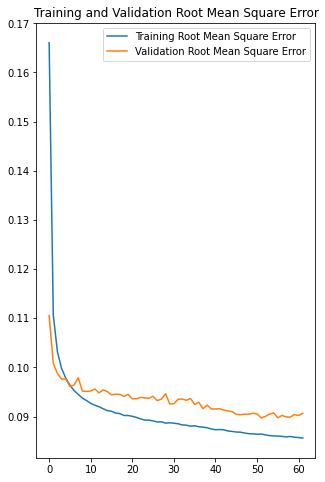

In [ ]:
rmse = np.sqrt(bkk_history.history['loss'])
val_rmse = np.sqrt(bkk_history.history['val_loss'])

epochs_range = range(len(bkk_history.history['loss']))

plt.figure(figsize=(5, 8))
plt.plot(epochs_range, rmse, label='Training Root Mean Square Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Square Error')
plt.legend(loc='upper right')
plt.title('Training and Validation Root Mean Square Error')
plt.show()

# Chanthaburi

## Data preparation

In [ ]:
cti_pm25_train = pd.read_csv(os.path.join(path, 'Chanthaburi/Train/Chanthaburi.txt'), delimiter = '\t', skiprows=10, header=None,
            names=['year', 'month', 'day', 'UTC hour', 'PM2.5', 'PM10_mask', 'Retrospective'])
cti_pm25_train = preparePM25(cti_pm25_train)
cti_pm25_train = changeTimezone(cti_pm25_train)
cti_pm25_train = addDay(cti_pm25_train)
cti_pm25_train = cti_pm25_train.set_index('datetime')

cti_pm25_test = pd.read_csv(os.path.join(path, 'Chanthaburi/Test/Chanthaburi.csv'), skiprows=1,
                            names=['datetime', 'PM2.5'])
cti_pm25_test['datetime'] = pd.to_datetime(cti_pm25_test['datetime'])
cti_pm25_test = addDay(cti_pm25_test)
cti_pm25_test = cti_pm25_test.set_index('datetime')

cti_temp_train = prepareTempAndWind('Chanthaburi/Train/3H_temperature_Chanthaburi.csv')

cti_temp_test = prepareTempAndWind('Chanthaburi/Test/3H_temperature_Chanthaburi.csv')

cti_wind_train = prepareTempAndWind('Chanthaburi/Train/3H_wind_Chanthaburi.csv')

cti_wind_test = prepareTempAndWind('Chanthaburi/Test/3H_wind_Chanthaburi.csv')

cti_train = prepareData(cti_pm25_train, cti_temp_train, cti_wind_train, fire)
cti_test = prepareData(cti_pm25_test, cti_temp_test, cti_wind_test, fire)

cti_train = addPM25Lastyear(cti_train)
cti_test = addPM25LastyearForTest(cti_test, cti_train)

cti_train.to_csv(os.path.join(path, 'Chanthaburi', 'cti_train.csv'))
cti_test.to_csv(os.path.join(path, 'Chanthaburi', 'cti_test.csv'))

cti_train, cti_test, scaler = normalize(cti_train, cti_test)

In [ ]:
features = ['PM2.5', 'PM2.5_lastyear', 'day_of_year', 'Temp', 'hotspot_count_Thailand', 
            'hotspot_count_Cambodia', 'Wind Speed(km/h)', 'WindDir']

prev_hour = 12
n_features = len(features)

cti_X_train, cti_y_train = load_data(cti_train, n_in=prev_hour, features=features)
cti_X_test, cti_y_test = load_data_test(cti_test, cti_train, n_in=prev_hour, features=features)

## Build model

In [ ]:
layers = [n_features, prev_hour+1]

with strategy.scope():
    cti_model = Sequential()

    cti_model.add(GRU(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    cti_model.add(Dropout(0.2, seed=20))

    cti_model.add(GRU(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    cti_model.add(Dropout(0.2, seed=20))

    cti_model.add(Dense(72, activation='linear'))

    opt = keras.optimizers.Adam(learning_rate=0.0001)

    cti_model.compile(loss='mse', optimizer=opt)
cti_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 13, 128)           52992     
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 128)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 256)               296448    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 72)                18504     
Total params: 367,944
Trainable params: 367,944
Non-trainable params: 0
_________________________________________________________________


## Train model

In [ ]:
filepath = os.path.join(path, 'model3/Chanthaburi_best_model.hdf5')

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
callbacks_list = [checkpoint, early_stopping]

epochs = 100
cti_history = cti_model.fit(cti_X_train, cti_y_train, batch_size=128, epochs=epochs, validation_split=0.2, verbose=1, callbacks=callbacks_list)

Epoch 1/100
166/166 [==============================] - 10s 31ms/step - loss: 0.0325 - val_loss: 0.0088

Epoch 00001: val_loss improved from inf to 0.00877, saving model to /content/drive/Shareddrives/Data science project/PM2.5_kaggle_2021/model3/Chanthaburi_best_model.hdf5
Epoch 2/100
166/166 [==============================] - 3s 18ms/step - loss: 0.0098 - val_loss: 0.0080

Epoch 00002: val_loss improved from 0.00877 to 0.00804, saving model to /content/drive/Shareddrives/Data science project/PM2.5_kaggle_2021/model3/Chanthaburi_best_model.hdf5
Epoch 3/100
166/166 [==============================] - 3s 16ms/step - loss: 0.0089 - val_loss: 0.0079

Epoch 00003: val_loss improved from 0.00804 to 0.00790, saving model to /content/drive/Shareddrives/Data science project/PM2.5_kaggle_2021/model3/Chanthaburi_best_model.hdf5
Epoch 4/100
166/166 [==============================] - 3s 16ms/step - loss: 0.0084 - val_loss: 0.0078

Epoch 00004: val_loss improved from 0.00790 to 0.00778, saving model 

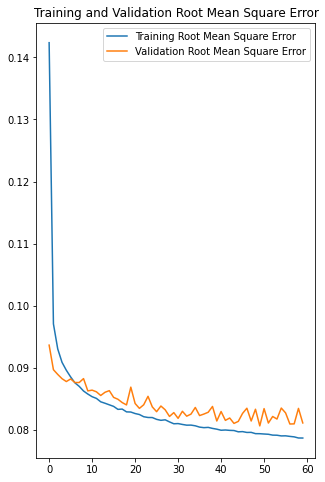

In [ ]:
rmse = np.sqrt(cti_history.history['loss'])
val_rmse = np.sqrt(cti_history.history['val_loss'])

epochs_range = range(len(cti_history.history['loss']))

plt.figure(figsize=(5, 8))
plt.plot(epochs_range, rmse, label='Training Root Mean Square Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Square Error')
plt.legend(loc='upper right')
plt.title('Training and Validation Root Mean Square Error')
plt.show()

# Chiang Mai

## Data preparation

In [ ]:
cmi_pm25_train = pd.read_csv(os.path.join(path, 'Chiang Mai/Train/Chiang Mai.txt'), delimiter = '\t', skiprows=10, header=None,
            names=['year', 'month', 'day', 'UTC hour', 'PM2.5', 'PM10_mask', 'Retrospective'])
cmi_pm25_train = preparePM25(cmi_pm25_train)
cmi_pm25_train = changeTimezone(cmi_pm25_train)
cmi_pm25_train = addDay(cmi_pm25_train)
cmi_pm25_train = cmi_pm25_train.set_index('datetime')

cmi_pm25_test = pd.read_csv(os.path.join(path, 'Chiang Mai/Test/Chiang Mai.csv'), skiprows=1,
                            names=['datetime', 'PM2.5'])
cmi_pm25_test['datetime'] = pd.to_datetime(cmi_pm25_test['datetime'])
cmi_pm25_test = addDay(cmi_pm25_test)
cmi_pm25_test = cmi_pm25_test.set_index('datetime')

cmi_temp_train = prepareTempAndWind('Chiang Mai/Train/3H_temperature_Chiang Mai.csv')

cmi_temp_test = prepareTempAndWind('Chiang Mai/Test/3H_temperature_Chiang Mai.csv')

cmi_wind_train = prepareTempAndWind('Chiang Mai/Train/3H_wind_Chiang Mai.csv')

cmi_wind_test = prepareTempAndWind('Chiang Mai/Test/3H_wind_Chiang Mai.csv')

cmi_train = prepareData(cmi_pm25_train, cmi_temp_train, cmi_wind_train, fire)
cmi_test = prepareData(cmi_pm25_test, cmi_temp_test, cmi_wind_test, fire)

cmi_train = addPM25Lastyear(cmi_train)
cmi_test = addPM25LastyearForTest(cmi_test, cmi_train)

cmi_train.to_csv(os.path.join(path, 'Chiang Mai', 'cmi_train.csv'))
cmi_test.to_csv(os.path.join(path, 'Chiang Mai', 'cmi_test.csv'))

cmi_train, cmi_test, scaler = normalize(cmi_train, cmi_test)

In [ ]:
features = ['PM2.5', 'day_of_year', 'PM2.5_lastyear', 'Temp', 'hotspot_count_Thailand', 
            'hotspot_count_Lao_PDR', 'hotspot_count_Myanmar', 'Wind Speed(km/h)', 'WindDir']
            
prev_hour = 36
n_features = len(features)

cmi_X_train, cmi_y_train = load_data(cmi_train, n_in=prev_hour, features=features)
cmi_X_test, cmi_y_test = load_data_test(cmi_test, cmi_train, n_in=prev_hour, features=features)

## Build model

In [ ]:
layers = [n_features, prev_hour+1]

with strategy.scope():
    cmi_model = Sequential()

    cmi_model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    cmi_model.add(Dropout(0.2, seed=20))

    cmi_model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    cmi_model.add(Dropout(0.2, seed=20))

    cmi_model.add(Dense(72, activation='linear'))

    opt = keras.optimizers.Adam(learning_rate=0.0001)

    cmi_model.compile(loss='mse', optimizer=opt)
cmi_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 37, 256)           272384    
_________________________________________________________________
dropout_4 (Dropout)          (None, 37, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 72)                18504     
Total params: 816,200
Trainable params: 816,200
Non-trainable params: 0
_________________________________________________________________


## Train model

In [ ]:
filepath = os.path.join(path, 'model3/Chiang Mai_best_model.hdf5')

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
callbacks_list = [checkpoint, early_stopping]

epochs = 100
cmi_history = cmi_model.fit(cmi_X_train, cmi_y_train, batch_size=128, epochs=epochs, validation_split=0.2, verbose=1, callbacks=callbacks_list)

Epoch 1/100
166/166 [==============================] - 12s 38ms/step - loss: 0.0169 - val_loss: 0.0042

Epoch 00001: val_loss improved from inf to 0.00417, saving model to /content/drive/Shareddrives/Data science project/PM2.5_kaggle_2021/model3/Chiang Mai_best_model.hdf5
Epoch 2/100
166/166 [==============================] - 3s 19ms/step - loss: 0.0056 - val_loss: 0.0039

Epoch 00002: val_loss improved from 0.00417 to 0.00386, saving model to /content/drive/Shareddrives/Data science project/PM2.5_kaggle_2021/model3/Chiang Mai_best_model.hdf5
Epoch 3/100
166/166 [==============================] - 3s 19ms/step - loss: 0.0051 - val_loss: 0.0037

Epoch 00003: val_loss improved from 0.00386 to 0.00374, saving model to /content/drive/Shareddrives/Data science project/PM2.5_kaggle_2021/model3/Chiang Mai_best_model.hdf5
Epoch 4/100
166/166 [==============================] - 3s 19ms/step - loss: 0.0046 - val_loss: 0.0037

Epoch 00004: val_loss improved from 0.00374 to 0.00367, saving model to 

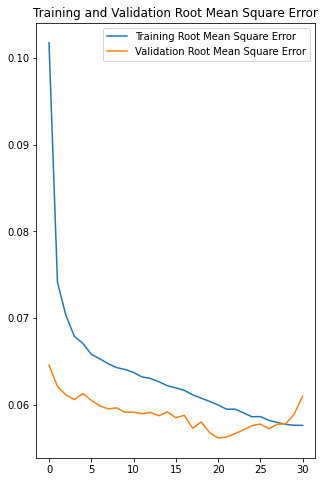

In [ ]:
rmse = np.sqrt(cmi_history.history['loss'])
val_rmse = np.sqrt(cmi_history.history['val_loss'])

epochs_range = range(len(cmi_history.history['val_loss']))

plt.figure(figsize=(5, 8))
plt.plot(epochs_range, rmse, label='Training Root Mean Square Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Square Error')
plt.legend(loc='upper right')
plt.title('Training and Validation Root Mean Square Error')
plt.show()

# Kanchanaburi

## Data preparation

In [ ]:
kri_pm25_train = pd.read_csv(os.path.join(path, 'Kanchanaburi/Train/Kanchanaburi.txt'), delimiter = '\t', skiprows=10, header=None,
            names=['year', 'month', 'day', 'UTC hour', 'PM2.5', 'PM10_mask', 'Retrospective'])
kri_pm25_train = preparePM25(kri_pm25_train)
kri_pm25_train = changeTimezone(kri_pm25_train)
kri_pm25_train = addDay(kri_pm25_train)
kri_pm25_train = kri_pm25_train.set_index('datetime')

kri_pm25_test = pd.read_csv(os.path.join(path, 'Kanchanaburi/Test/Kanchanaburi.csv'), skiprows=1,
                            names=['datetime', 'PM2.5'])
kri_pm25_test['datetime'] = pd.to_datetime(kri_pm25_test['datetime'])
kri_pm25_test = addDay(kri_pm25_test)
kri_pm25_test = kri_pm25_test.set_index('datetime')

kri_temp_train = prepareTempAndWind('Kanchanaburi/Train/3H_temperature_Kanchanaburi.csv')

kri_temp_test = prepareTempAndWind('Kanchanaburi/Test/3H_temperature_Kanchanaburi.csv')

kri_wind_train = prepareTempAndWind('Kanchanaburi/Train/3H_wind_Kanchanaburi.csv')

kri_wind_test = prepareTempAndWind('Kanchanaburi/Test/3H_wind_Kanchanaburi.csv')

kri_train = prepareData(kri_pm25_train, kri_temp_train, kri_wind_train, fire)
kri_test = prepareData(kri_pm25_test, kri_temp_test, kri_wind_test, fire)

kri_train = addPM25Lastyear(kri_train)
kri_test = addPM25LastyearForTest(kri_test, kri_train)

kri_train.to_csv(os.path.join(path, 'Kanchanaburi', 'kri_train.csv'))
kri_test.to_csv(os.path.join(path, 'Kanchanaburi', 'kri_test.csv'))

kri_train, kri_test, scaler = normalize(kri_train, kri_test)

In [ ]:
features = ['PM2.5', 'PM2.5_lastyear', 'day_of_year', 'Temp', 'hotspot_count_Thailand', 
            'Wind Speed(km/h)', 'WindDir']
            
prev_hour = 36
n_features = len(features)

kri_X_train, kri_y_train = load_data(kri_train, n_in=prev_hour, features=features)
kri_X_test, kri_y_test = load_data_test(kri_test, kri_train, n_in=prev_hour, features=features)

## Build model

In [ ]:
layers = [n_features, prev_hour+1]

with strategy.scope():
    kri_model = Sequential()

    kri_model.add(GRU(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    kri_model.add(Dropout(0.2, seed=20))

    kri_model.add(GRU(128, input_shape=(layers[1], layers[0]), return_sequences=False))
    kri_model.add(Dropout(0.3, seed=20))

    kri_model.add(Dense(72, activation='linear'))

    opt = keras.optimizers.Adam(learning_rate=0.0001)

    kri_model.compile(loss='mse', optimizer=opt)
kri_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 37, 128)           52608     
_________________________________________________________________
dropout_6 (Dropout)          (None, 37, 128)           0         
_________________________________________________________________
gru_5 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 72)                9288      
Total params: 160,968
Trainable params: 160,968
Non-trainable params: 0
_________________________________________________________________


## Train model

In [ ]:
filepath = os.path.join(path, 'model3/Kanchanaburi_best_model.hdf5')

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
callbacks_list = [checkpoint, early_stopping]

epochs = 100
kri_history = kri_model.fit(kri_X_train, kri_y_train, batch_size=128, epochs=epochs, validation_split=0.2, verbose=1, callbacks=callbacks_list)

Epoch 1/100
166/166 [==============================] - 10s 33ms/step - loss: 0.0223 - val_loss: 0.0102

Epoch 00001: val_loss improved from inf to 0.01023, saving model to /content/drive/Shareddrives/Data science project/PM2.5_kaggle_2021/model3/Kanchanaburi_best_model.hdf5
Epoch 2/100
166/166 [==============================] - 3s 17ms/step - loss: 0.0069 - val_loss: 0.0085

Epoch 00002: val_loss improved from 0.01023 to 0.00854, saving model to /content/drive/Shareddrives/Data science project/PM2.5_kaggle_2021/model3/Kanchanaburi_best_model.hdf5
Epoch 3/100
166/166 [==============================] - 3s 17ms/step - loss: 0.0058 - val_loss: 0.0081

Epoch 00003: val_loss improved from 0.00854 to 0.00808, saving model to /content/drive/Shareddrives/Data science project/PM2.5_kaggle_2021/model3/Kanchanaburi_best_model.hdf5
Epoch 4/100
166/166 [==============================] - 3s 17ms/step - loss: 0.0051 - val_loss: 0.0082

Epoch 00004: val_loss did not improve from 0.00808
Epoch 5/100
166

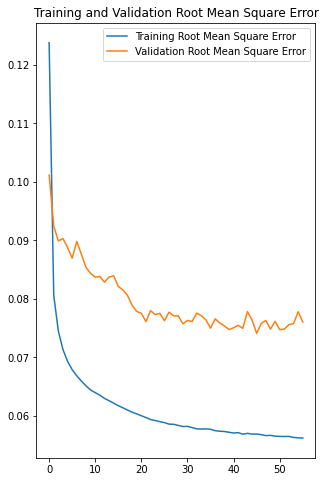

In [ ]:
rmse = np.sqrt(kri_history.history['loss'])
val_rmse = np.sqrt(kri_history.history['val_loss'])

epochs_range = range(len(kri_history.history['loss']))

plt.figure(figsize=(5, 8))
plt.plot(epochs_range, rmse, label='Training Root Mean Square Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Square Error')
plt.legend(loc='upper right')
plt.title('Training and Validation Root Mean Square Error')
plt.show()

# Khon Kaen

## Data preparation

In [ ]:
def preparePM25ForKhonKaen(df):
    df.loc[df['PM2.5'] > 500, 'PM2.5'] = df['PM2.5'].mean()
    df = combineDateTime(df)
    df = df.drop(['PM10_mask', 'Retrospective'], axis=1)
    df = resampling(df, 1)
    for i in range(8852, 14283):
        df.iloc[i] = (df.iloc[i+365*24] + df.iloc[i-365*24])/2
    return df

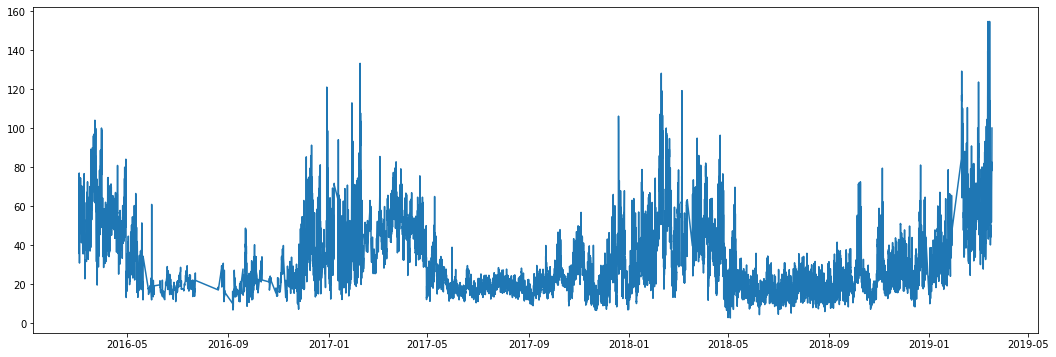

In [ ]:
kkn_pm25_train = pd.read_csv(os.path.join(path, 'Khon Kaen/Train/Khon Kaen.txt'), delimiter = '\t', skiprows=10, header=None,
            names=['year', 'month', 'day', 'UTC hour', 'PM2.5', 'PM10_mask', 'Retrospective'])
kkn_pm25_train = preparePM25ForKhonKaen(kkn_pm25_train)

plt.figure(figsize=(18,6))
plt.plot(kkn_pm25_train['PM2.5'])
plt.show()

In [ ]:
kkn_pm25_train = changeTimezone(kkn_pm25_train)
kkn_pm25_train = addDay(kkn_pm25_train)
kkn_pm25_train = kkn_pm25_train.set_index('datetime')

kkn_pm25_test = pd.read_csv(os.path.join(path, 'Khon Kaen/Test/Khon Kaen.csv'), skiprows=1,
                            names=['datetime', 'PM2.5'])
kkn_pm25_test['datetime'] = pd.to_datetime(kkn_pm25_test['datetime'])
kkn_pm25_test = addDay(kkn_pm25_test)
kkn_pm25_test = kkn_pm25_test.set_index('datetime')

kkn_temp_train = prepareTempAndWind('Khon Kaen/Train/3H_temperature_Khon Kaen.csv')

kkn_temp_test = prepareTempAndWind('Khon Kaen/Test/3H_temperature_Khon Kaen.csv')

kkn_wind_train = prepareTempAndWind('Khon Kaen/Train/3H_wind_Khon Kaen.csv')

kkn_wind_test = prepareTempAndWind('Khon Kaen/Test/3H_wind_Khon Kaen.csv')

kkn_train = prepareData(kkn_pm25_train, kkn_temp_train, kkn_wind_train, fire)
kkn_test = prepareData(kkn_pm25_test, kkn_temp_test, kkn_wind_test, fire)

kkn_train = addPM25Lastyear(kkn_train)
kkn_test = addPM25LastyearForTest(kkn_test, kkn_train)

kkn_train.to_csv(os.path.join(path, 'Khon Kaen', 'kkn_train.csv'))
kkn_test.to_csv(os.path.join(path, 'Khon Kaen', 'kkn_test.csv'))

kkn_train, kkn_test, scaler = normalize(kkn_train, kkn_test)

In [ ]:
features = ['PM2.5', 'PM2.5_lastyear', 'day_of_year', 'Temp', 'hotspot_count_Thailand', 
            'hotspot_count_Lao_PDR', 'Wind Speed(km/h)', 'WindDir']
prev_hour = 36
n_features = len(features)

kkn_X_train, kkn_y_train = load_data(kkn_train, n_in=prev_hour, features=features)
kkn_X_test, kkn_y_test = load_data_test(kkn_test, kkn_train, n_in=prev_hour, features=features)

## Build model

In [ ]:
layers = [n_features, prev_hour+1]

with strategy.scope():
    kkn_model = Sequential()

    kkn_model.add(GRU(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    kkn_model.add(Dropout(0.3, seed=20))

    kkn_model.add(GRU(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    kkn_model.add(Dropout(0.4, seed=20))

    kkn_model.add(Dense(72, activation='linear'))

    opt = keras.optimizers.Adam(learning_rate=0.0001)

    kkn_model.compile(loss='mse', optimizer=opt)
kkn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 37, 128)           52992     
_________________________________________________________________
dropout_8 (Dropout)          (None, 37, 128)           0         
_________________________________________________________________
gru_7 (GRU)                  (None, 256)               296448    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 72)                18504     
Total params: 367,944
Trainable params: 367,944
Non-trainable params: 0
_________________________________________________________________


## Train model

In [ ]:
filepath = os.path.join(path, 'model3/Khon Kaen_best_model.hdf5')

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
callbacks_list = [checkpoint, early_stopping]

epochs = 100
kkn_history = kkn_model.fit(kkn_X_train, kkn_y_train, batch_size=128, epochs=epochs, validation_split=0.2, verbose=1, callbacks=callbacks_list)

Epoch 1/100
166/166 [==============================] - 10s 34ms/step - loss: 0.0261 - val_loss: 0.0088

Epoch 00001: val_loss improved from inf to 0.00882, saving model to /content/drive/Shareddrives/Data science project/PM2.5_kaggle_2021/model3/Khon Kaen_best_model.hdf5
Epoch 2/100
166/166 [==============================] - 3s 19ms/step - loss: 0.0080 - val_loss: 0.0080

Epoch 00002: val_loss improved from 0.00882 to 0.00801, saving model to /content/drive/Shareddrives/Data science project/PM2.5_kaggle_2021/model3/Khon Kaen_best_model.hdf5
Epoch 3/100
166/166 [==============================] - 3s 19ms/step - loss: 0.0069 - val_loss: 0.0072

Epoch 00003: val_loss improved from 0.00801 to 0.00718, saving model to /content/drive/Shareddrives/Data science project/PM2.5_kaggle_2021/model3/Khon Kaen_best_model.hdf5
Epoch 4/100
166/166 [==============================] - 3s 19ms/step - loss: 0.0062 - val_loss: 0.0068

Epoch 00004: val_loss improved from 0.00718 to 0.00680, saving model to /co

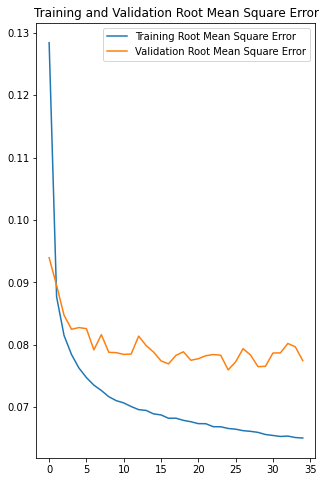

In [ ]:
rmse = np.sqrt(kkn_history.history['loss'])
val_rmse = np.sqrt(kkn_history.history['val_loss'])

epochs_range = range(len(kkn_history.history['loss']))

plt.figure(figsize=(5, 8))
plt.plot(epochs_range, rmse, label='Training Root Mean Square Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Square Error')
plt.legend(loc='upper right')
plt.title('Training and Validation Root Mean Square Error')
plt.show()

# Songkhla

## Data preparation

In [ ]:
ska_pm25_train = pd.read_csv(os.path.join(path, 'Songkhla/Train/Songkhla.txt'), delimiter = '\t', skiprows=10, header=None,
            names=['year', 'month', 'day', 'UTC hour', 'PM2.5', 'PM10_mask', 'Retrospective'])
ska_pm25_train = preparePM25(ska_pm25_train)
ska_pm25_train = changeTimezone(ska_pm25_train)
ska_pm25_train = addDay(ska_pm25_train)
ska_pm25_train = ska_pm25_train.set_index('datetime')

ska_pm25_test = pd.read_csv(os.path.join(path, 'Songkhla/Test/Songkhla.csv'), skiprows=1,
                            names=['datetime', 'PM2.5'])
ska_pm25_test['datetime'] = pd.to_datetime(ska_pm25_test['datetime'])
ska_pm25_test = addDay(ska_pm25_test)
ska_pm25_test = ska_pm25_test.set_index('datetime')

ska_temp_train = prepareTempAndWind('Songkhla/Train/3H_temperature_Songkhla.csv')

ska_temp_test = prepareTempAndWind('Songkhla/Test/3H_temperature_Songkhla.csv')

ska_wind_train = prepareTempAndWind('Songkhla/Train/3H_wind_Songkhla.csv')

ska_wind_test = prepareTempAndWind('Songkhla/Test/3H_wind_Songkhla.csv')

ska_train = prepareData(ska_pm25_train, ska_temp_train, ska_wind_train, fire)
ska_test = prepareData(ska_pm25_test, ska_temp_test, ska_wind_test, fire)

ska_train = addPM25Lastyear(ska_train)
ska_test = addPM25LastyearForTest(ska_test, ska_train)

ska_train.to_csv(os.path.join(path, 'Songkhla', 'ska_train.csv'))
ska_test.to_csv(os.path.join(path, 'Songkhla', 'ska_test.csv'))

ska_train, ska_test, scaler = normalize(ska_train, ska_test)

In [ ]:
features = ['PM2.5', 'PM2.5_lastyear', 'day_of_year', 'Temp', 'hotspot_count_Thailand', 
            'Wind Speed(km/h)', 'WindDir']
            
prev_hour = 12
n_features = len(features)

ska_X_train, ska_y_train = load_data(ska_train, n_in=prev_hour, features=features)
ska_X_test, ska_y_test = load_data_test(ska_test, ska_train, n_in=prev_hour, features=features)

## Build model

In [ ]:
layers = [n_features, prev_hour+1]

with strategy.scope():
    ska_model = Sequential()

    ska_model.add(GRU(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    ska_model.add(Dropout(0.2, seed=20))

    ska_model.add(GRU(128, input_shape=(layers[1], layers[0]), return_sequences=False))
    ska_model.add(Dropout(0.3, seed=20))

    ska_model.add(Dense(72, activation='linear'))

    opt = keras.optimizers.Adam(learning_rate=0.0001)

    ska_model.compile(loss='mse', optimizer=opt)
ska_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 13, 128)           52608     
_________________________________________________________________
dropout_10 (Dropout)         (None, 13, 128)           0         
_________________________________________________________________
gru_9 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 72)                9288      
Total params: 160,968
Trainable params: 160,968
Non-trainable params: 0
_________________________________________________________________


## Train model

In [ ]:
filepath = os.path.join(path, 'model3/Songkhla_best_model.hdf5')

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
callbacks_list = [checkpoint, early_stopping]

epochs = 100
ska_history = ska_model.fit(ska_X_train, ska_y_train, batch_size=128, epochs=epochs, validation_split=0.2, verbose=1, callbacks=callbacks_list)

Epoch 1/100
166/166 [==============================] - 10s 30ms/step - loss: 0.0330 - val_loss: 0.0058

Epoch 00001: val_loss improved from inf to 0.00578, saving model to /content/drive/Shareddrives/Data science project/PM2.5_kaggle_2021/model3/Songkhla_best_model.hdf5
Epoch 2/100
166/166 [==============================] - 3s 16ms/step - loss: 0.0089 - val_loss: 0.0047

Epoch 00002: val_loss improved from 0.00578 to 0.00470, saving model to /content/drive/Shareddrives/Data science project/PM2.5_kaggle_2021/model3/Songkhla_best_model.hdf5
Epoch 3/100
166/166 [==============================] - 3s 15ms/step - loss: 0.0069 - val_loss: 0.0045

Epoch 00003: val_loss improved from 0.00470 to 0.00446, saving model to /content/drive/Shareddrives/Data science project/PM2.5_kaggle_2021/model3/Songkhla_best_model.hdf5
Epoch 4/100
166/166 [==============================] - 3s 15ms/step - loss: 0.0061 - val_loss: 0.0044

Epoch 00004: val_loss improved from 0.00446 to 0.00440, saving model to /conte

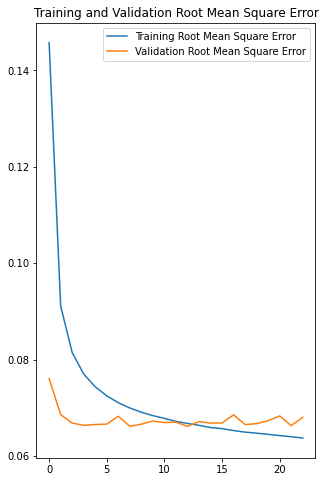

In [ ]:
rmse = np.sqrt(ska_history.history['loss'])
val_rmse = np.sqrt(ska_history.history['val_loss'])

epochs_range = range(len(ska_history.history['loss']))

plt.figure(figsize=(5, 8))
plt.plot(epochs_range, rmse, label='Training Root Mean Square Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Square Error')
plt.legend(loc='upper right')
plt.title('Training and Validation Root Mean Square Error')
plt.show()